# Import necessary libraries

In [28]:
# Enable inline backend for plotting library so the plots are displayed in jupyter
%matplotlib inline
import tensorflow as tf # Build and train matching models...
import matplotlib.pyplot as plt # Create figures and plots for visualising data
import numpy as np # For numerical computations involving arrays and matrices
import os # To interact with the OS flie explorer
import PIL # Python Imaging Library - Open, manipulate, and/or save multiple image file formats
import PIL.Image # Same as above
import tensorflow_datasets as tfds # To provide datasets ready to use with tensorflow
import pathlib # Object oriented file system path manipulation

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

# Load data and preprocess it

## Option 1:
Download the dataset directly from the provided link. If this does not work, try Option **2**

In [29]:
dataset_url = 'http://vision.roboslang.org/open_datasets/pneumonia_dataset.zip'
# Using wget below to download the dataset from the provided URL and unzipping for extraction
!wget http://vision.roboslang.org/open_datasets/pneumonia_dataset.zip
!unzip pneumonia_dataset.zip


--2023-11-27 02:29:58--  http://vision.roboslang.org/open_datasets/pneumonia_dataset.zip
Resolving vision.roboslang.org (vision.roboslang.org)... 208.113.173.23
Connecting to vision.roboslang.org (vision.roboslang.org)|208.113.173.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86257778 (82M) [application/zip]
Saving to: ‘pneumonia_dataset.zip.1’

pneumonia_dataset.z 100%[===================>]  82.26M  1.53MB/s    in 51s     

2023-11-27 02:30:50 (1.60 MB/s) - ‘pneumonia_dataset.zip.1’ saved [86257778/86257778]

Archive:  pneumonia_dataset.zip
replace pneumonia_dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: pneumonia_dataset/.DS_Store  
  inflating: __MACOSX/pneumonia_dataset/._.DS_Store  
  inflating: pneumonia_dataset/test/.DS_Store  
  inflating: __MACOSX/pneumonia_dataset/test/._.DS_Store  
  inflating: pneumonia_dataset/train/.DS_Store  
  inflating: __MACOSX/pneumonia_dataset/train/._.DS_Store  
  inflating: pneumonia_dataset/t

## Option 2:
If downloading the dataset from the link is too slow or the link is no longer working, download the dataset from Brigthspace, and upload it to the sample_data folder in Google Colab. For this, open the Files in the left hand side menu, and click the upload button, or drag and drop the archive in the folder you want. Depending on where you have copied this file, you might have to change the path below.



When you upload from the interface sometimes you don't get a lot of feedback for when the upload is done. You can also try to force the upload window to open by executing the below code.

In [30]:
from google.colab import files
files.upload()

{}

In [31]:
# For option 2, after you have copied the data locally, point the dataset_url to the local path

dataset_url = '/content/sample_data/datasets/pneumonia_dataset.zip'

##Preprocess the data

In [32]:
out_path = '/content/sample_data/' # Define the output path where the downloaded data will be saved

# Use the TensorFlow Keras utility to download the dataset from the given URL and extract it to a defined output
archive = tf.keras.utils.get_file(origin=dataset_url, cache_dir='/content/sample_data/', extract=True)

In [33]:
# Create a 'pathlib.Path' object for the downloaded archive
# Pathlib module offers classes representing filesystem paths with semantics
# appropriate for different operating systems.
data_dir = pathlib.Path(archive).with_suffix('') # This allows for easy manipulation of the filesystem paths and is OS agnostic
# Pathlib's width suffix is used to ensure the path is correctly formatted

In [34]:
# Count the number of images in a specific directory
image_count = len(list(data_dir.glob('./train/pneumonia/*.jpeg')))
print(image_count)
# This quickly checks to confirm the expected amount of images are present

100


In [35]:
# The dataset is organised into train and test folders, with subfolders for "normal" & "pneumonia" classes
# The following code counts the number of images in each category for both training and testing datasets
train_normal_count = len(list(data_dir.glob('train/normal/*.jpeg'))) # Count the number of normal images in the training set
train_pneumonia_count = len(list(data_dir.glob('train/pneumonia/*.jpeg')))  # Count the number of pneumonia images in the training set
test_normal_count = len(list(data_dir.glob('test/normal/*.jpeg'))) # Count the number of normal images in the testing set
test_pneumonia_count = len(list(data_dir.glob('test/pneumonia/*.jpeg'))) # Count the number of pneumonia images in the testing set

# Prints all of the above counts
print(f"Training normal: {train_normal_count}")
print(f"Training pneumonia: {train_pneumonia_count}")
print(f"Training normal: {test_normal_count}")
print(f"Training pneumonia: {test_pneumonia_count}")

Training normal: 100
Training pneumonia: 100
Training normal: 50
Training pneumonia: 50


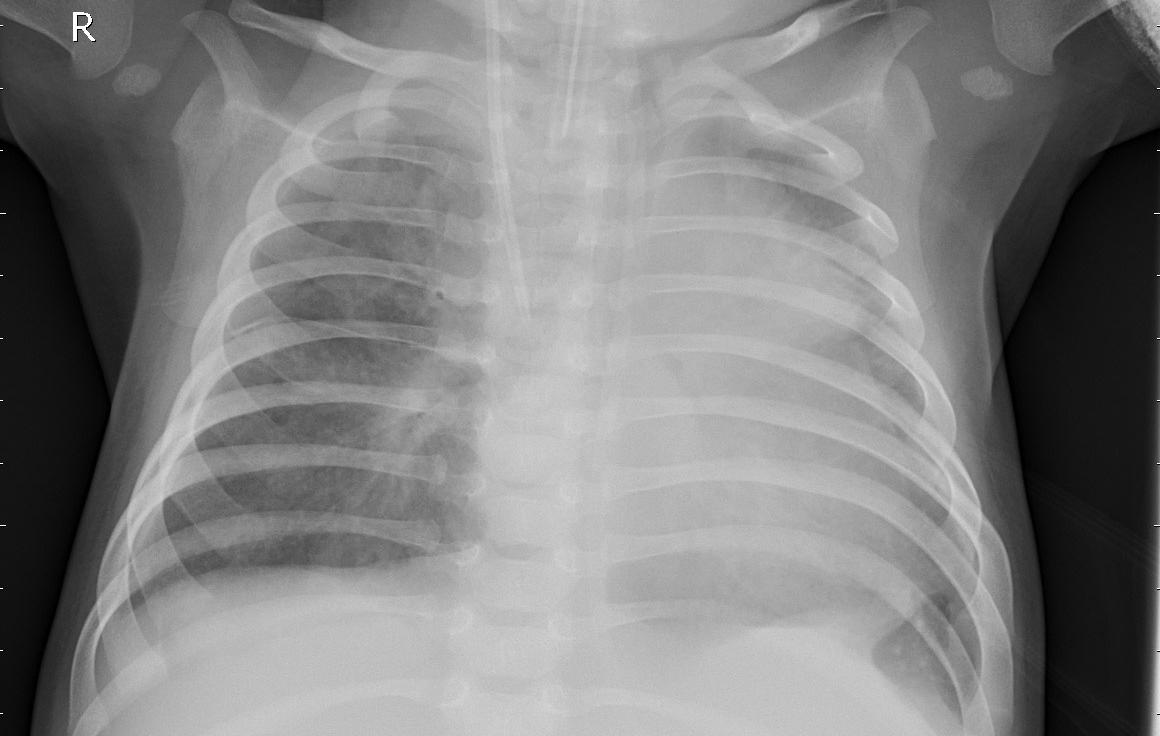

In [36]:
# Create a list of file paths for pneumonia images
pneumonia_images = list(data_dir.glob('train/pneumonia/*'))
# Open and display the first pneumonia image in the list
PIL.Image.open(str(pneumonia_images[0]))

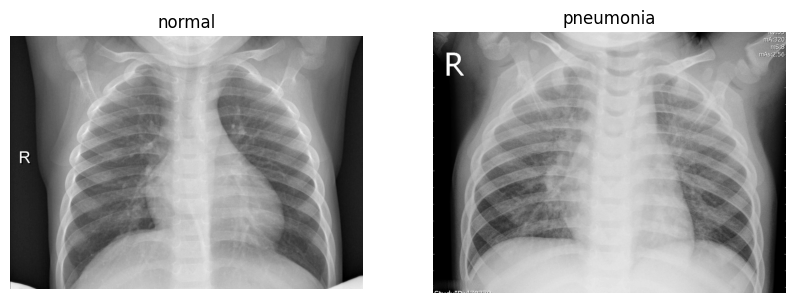

In [37]:
# Set up the figure for plotting the images with matplotlib
plt.figure(figsize = (10, 4))

# Loop over "normal" and "pneumonia" to display images from each
for i, category in enumerate(['normal', 'pneumonia']):
  image_path = list(data_dir.glob(f'test/{category}/*.jpeg'))[0] # Obtain the first image path form the test dataset for the current category
  img = PIL.Image.open(str(image_path)) # Open the image file using PIL

  plt.subplot(1, 2, i+1) # Plot the image in a 1x2 grid (1r, 2c), at position i+1
  plt.title(category) # Set the title of the subplot to the category of the image
  plt.imshow(img, cmap = 'gray') # Display the image in grayscale
  plt.axis('off') # Turn off axis to remove scale

plt.show() # Display the plot with both images


# Define a deep learning model that will learn the differences between pneumonia and normal CT images


In [38]:
# Define batch size and image dimensions for training

from PIL import Image # Import image class from PIL to process images

image_path = list(data_dir.glob('train/pneumonia/*.jpeg'))[0] # Retrieve the file path of first image in the set
image = Image.open(str(image_path)) # Open the image file to access its properties
print(img.size) # Prints the width, height

# Batch size will be the number of samples before the model's weights are updated
batch_size = 32
# Define the width and height the images will be resized in for processing
img_width = 224
img_height = 224


(1328, 984)


In [39]:
# Use the os.path.join to construct the file path to the training data directory
train_data_dir  = os.path.join(data_dir,'train') # This line is to construct the path correctly regardless of OS
test_data_dir = os.path.join(data_dir,'test') # Construct the file path to the testing data directory

In [40]:
# Import the fucntion to create a dataset from image files
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Set a seed for reproducibility so that the random operations can be replicated
seed = 123

# Create a training dataset using "image_dataset_from_directory"
train_ds = image_dataset_from_directory(
    directory = train_data_dir, # Path to the training directory
    validation_split = 0.2, # Allocate 20% of the images for validation, 100*0.2
    subset = "training", # Specify the dataset will be used for training
    seed = seed, # Use the value set earlier as current seed
    image_size = (img_height, img_width), # Resize all images to the values set previously
    batch_size = batch_size) # Set the number of images to be processed in one run to the batch_size set earlier

# Create a validation dataset using the same directory. Very similar to the training dataset
val_ds = image_dataset_from_directory(
    directory = train_data_dir, # Path to the training directory
    validation_split = 0.2, # Allocate 20% of the images for validation, 100*0.2
    subset = "validation", # Specify the dataset will be used for validation
    seed = seed, # Use the value set earlier as current seed
    image_size = (img_height, img_width), # Resize all images to the values set previously
    batch_size = batch_size) # Set the number of images to be processed in one run to the batch_size set earlier

Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.


In [41]:
# Create a layer to normalise pixel values to the [0, 1] range.
# By default, when you load an image, each pixel value will have a value between 0-255
# but, in neural networks, we need as input normalised values in [0,1] interval.
# Dividing by 255 scales these values to the required [0, 1] range, which is a preprocessing set for image data.
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [42]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Apply normalisation layer to each image in the datase.
# Get the first batch of images and labels, from the normalized dataset.
image_batch, labels_batch = next(iter(normalized_ds)) # "iter" creates an iterator for the dataset. "next" retrieves the first element from this iterator
first_image = image_batch[0] # Extract the first image from the batch for inspection

# Print the minimum and maximum pixel values of the first image to verify normalization
# Additionally, print out the first three pixel values of the first image as example
# np.min() and np.max() are used to find the lowest and highest pixel value, confirming they are in range [0, 1]
print(np.min(first_image), np.max(first_image), first_image[0][0])

0.0 0.9990195 tf.Tensor([0.6882604 0.6882604 0.6882604], shape=(3,), dtype=float32)


In [43]:
# Define the number of classes in the classification problem.
num_classes = 2 # We only have "normal" and "pneumonia" classes, so 2


In [ ]:
# Import necessary modules from TensorFlow to create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    # Convolutional Layer. Learn 32 filters using a 3x3 kernel
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (img_height, img_width, 3)),
    BatchNormalization(),

    # Same layer as above. Double number of filters
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),

    # Flatten the output of convolutional layer
    Flatten(),

    # Dropout for regularization
    Dropout(0.5),

    # Hidden layer with 128 units and relu activation with 50% dropout
    Dense(128, activation = 'relu'),
      Dropout(0.5),

    # Output layer with "num_classes" neurons, one for each class, using softmax
    Dense(2, activation = 'softmax')
])

In [ ]:
# Compile the NN model
model.compile(
  optimizer = 'adam', # "adam" is an optimization algorithm that adjusts weights to minimize the loss
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics = ['accuracy']) # Monitor accuracy and F1 score during training

In [46]:
# Being training the model
history = model.fit(
    train_ds, # The training dataset
    epochs = 10, # Start with 10 epochs
    validation_data = val_ds # The validation dataset used to evaluate the model after each epoch
)

# After training, extract the accuracy for training and validation form the history object
train_acc = history.history['accuracy'] # Training accuracy after each epoch
val_acc = history.history['val_accuracy'] # Valication accuracy after each epoch

# Print out the most recent training and valiation accuracy
print(f"Training accuracy: {train_acc[-1]:.2f}")
print(f"Validation accuracy: {val_acc[-1]:.2f}")

Epoch 1/10
5/5 [==============================] - 5s 247ms/step - loss: 80.4426 - accuracy: 0.6375 - val_loss: 35.7706 - val_accuracy: 0.6750
Epoch 2/10
5/5 [==============================] - 2s 207ms/step - loss: 15.7297 - accuracy: 0.7937 - val_loss: 30.6193 - val_accuracy: 0.6500
Epoch 3/10
5/5 [==============================] - 2s 204ms/step - loss: 5.3710 - accuracy: 0.8813 - val_loss: 184.2726 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - 2s 205ms/step - loss: 3.5338 - accuracy: 0.8625 - val_loss: 33.5564 - val_accuracy: 0.5500
Epoch 5/10
5/5 [==============================] - 2s 209ms/step - loss: 2.3690 - accuracy: 0.8938 - val_loss: 4.9756 - val_accuracy: 0.8250
Epoch 6/10
5/5 [==============================] - 3s 289ms/step - loss: 0.5145 - accuracy: 0.9750 - val_loss: 7.1827 - val_accuracy: 0.8500
Epoch 7/10
5/5 [==============================] - 3s 284ms/step - loss: 0.5251 - accuracy: 0.9563 - val_loss: 3.9208 - val_accuracy: 0.9000
Epoch 8/10
5/

In [47]:
# Let's load the testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 2 classes.


In [48]:
# Evaluate the model on the test dataset and check accuracy
test_loss, test_acc = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

4/4 [==============================] - 1s 24ms/step - loss: 10.0451 - accuracy: 0.6800
Test Loss: 10.045068740844727
Test Accuracy: 0.6800000071525574


In [49]:
# Try to improve the model such that it performs well on both training and testing datasets.